## Tarefa (a) - Geração de Sequências de Bits

In [204]:
import numpy as np

# Geração de quatro sequências de bits pseudo aleatórias
np.random.seed(0)  # Garante a repetibilidade
bit_sequences = [np.random.randint(0, 2, 10000) for _ in range(4)]

In [205]:
print('3 primeiros símbolos (bits) de cada sinal:')
for i in range(4):
    print(f'S_{i}:{bit_sequences[i][:3]}')

3 primeiros símbolos (bits) de cada sinal:
S_0:[0 1 1]
S_1:[1 1 1]
S_2:[0 0 1]
S_3:[1 1 0]


## Tarefa (b) - Ilustração da Técnica FDM

Geramos 4 sinais 2-PAM com pulso retangular de energia unitária.

In [206]:
import matplotlib.pyplot as plt
from scipy.signal import periodogram

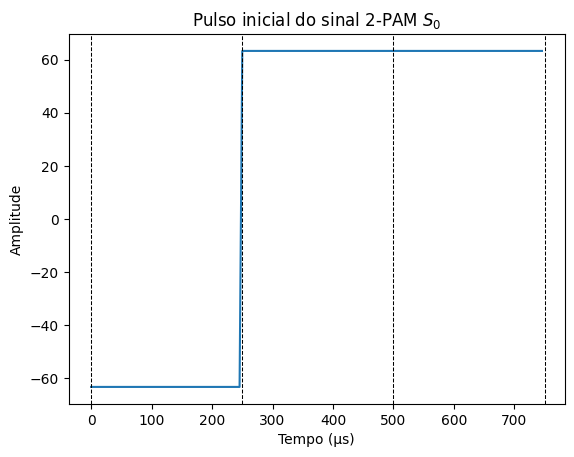

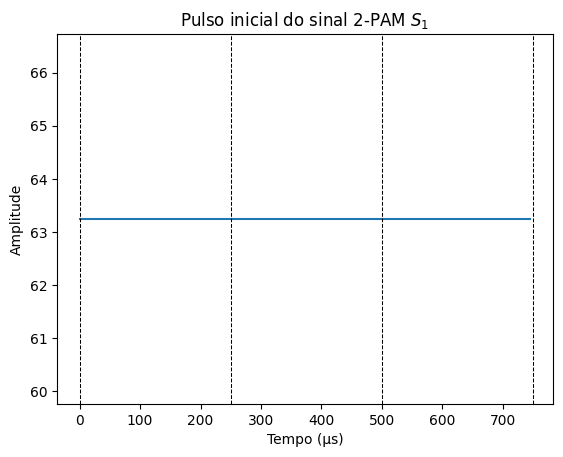

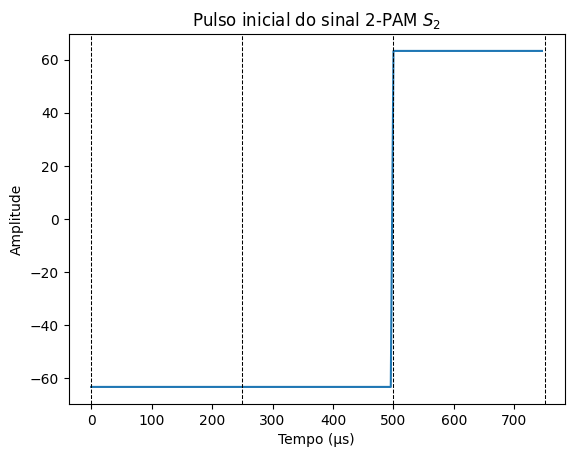

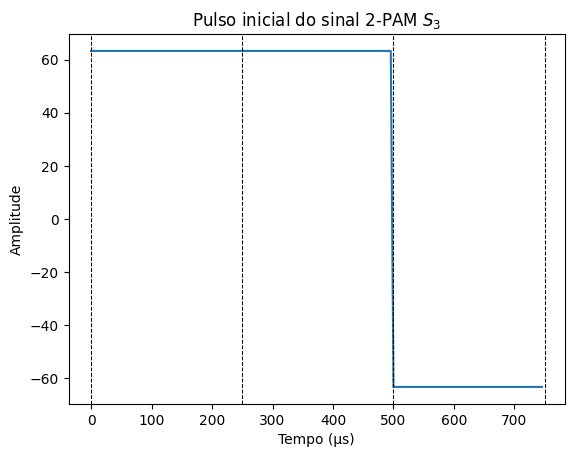

In [207]:
def generate_2PAM_sequence(bits, Ts, Fa):
    """Gera um sinal 2-PAM a partir de uma sequência de bits."""
    t = np.arange(0, len(bits)*Ts, 1/Fa)
    sinal = np.array([1 if bit else -1 for bit in bits])
    sinal = np.repeat(sinal, Fa*Ts)
    return t[:len(sinal)], sinal*Ts**(-0.5)

Ts = 1/4000  # Largura do pulso
Fa = 224000  # Frequência de amostragem

fdm_modulated_signals = []

for i, bits in enumerate(bit_sequences):
    t, sinal = generate_2PAM_sequence(bits, Ts, Fa)
    fdm_modulated_signals.append(sinal)
    # Plot dos 3 primeiros símbolos
    plt.plot(1e6 * t[:int(3*Fa*Ts)], sinal[:int(3*Fa*Ts)])
    # Adiciona linhas verticais para separar os símbolos
    for j in range(4):  
        plt.axvline(j * Ts * 1e6, color='k', linestyle='--', linewidth=0.75)  
    plt.xlabel('Tempo (μs)')
    plt.ylabel('Amplitude')
    plt.title(f'Pulso inicial do sinal 2-PAM $S_{i}$')
    plt.show()


## Tarefa (c) - Geração do Sinal Multiplexado na Frequência
## Tarefa (d) - Visualização no Domínio do Tempo

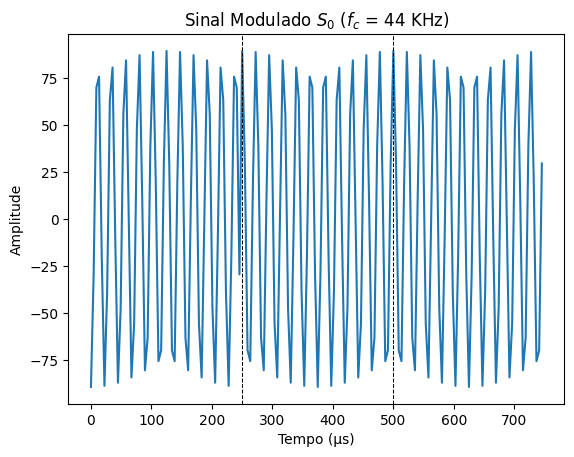

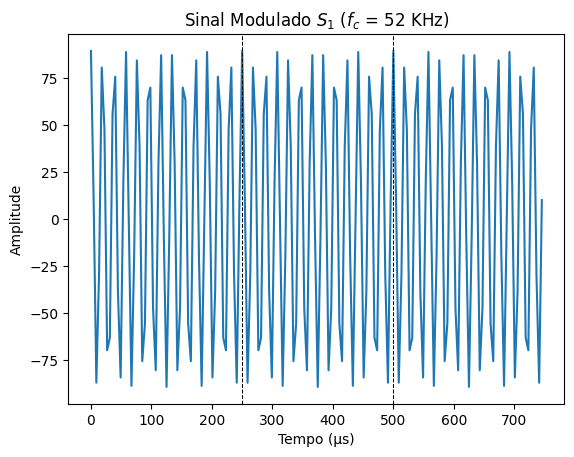

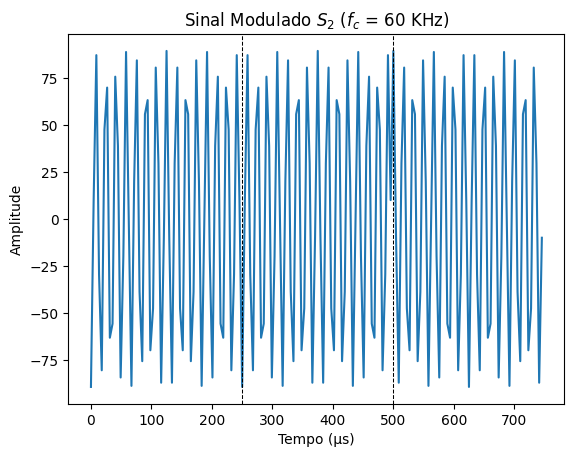

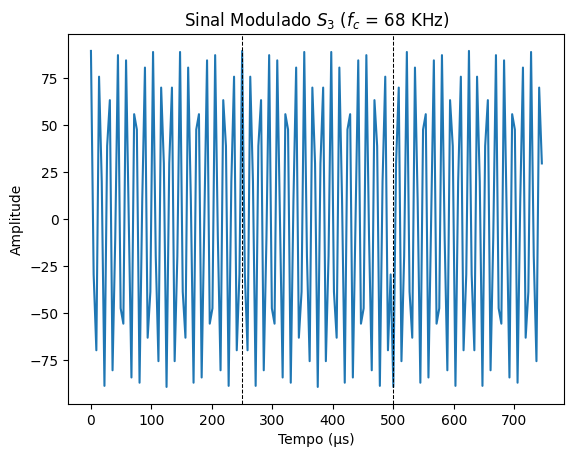

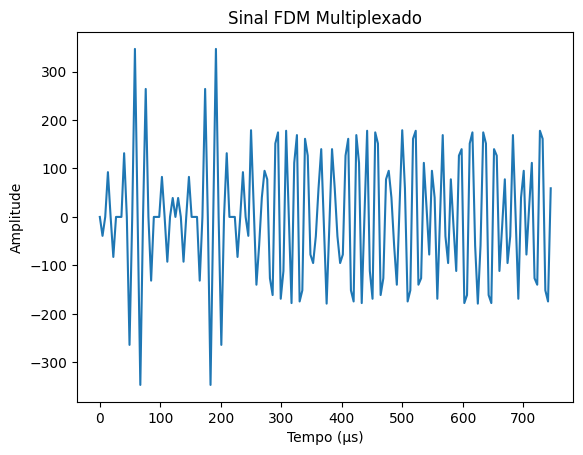

In [208]:
def modulate_signal(signal, fc, t):
    """Modula um sinal com uma portadora de frequência fc - 2-PAM em banda passante."""
    return signal * np.cos(2 * np.pi * fc * t) * np.sqrt(2)

fc_values = [44000, 52000, 60000, 68000]
multiplexed_fdm_signal = np.zeros_like(fdm_modulated_signals[0], dtype=float)

#destructuring
for i, (signal, fc) in enumerate(zip(fdm_modulated_signals, fc_values)):
    modulated_signal = modulate_signal(signal, fc, t)
    multiplexed_fdm_signal += modulated_signal

    # Plot do sinal modulado individualmente
    plt.plot(1e6 * t[:int(3*Fa*Ts)], modulated_signal[:int(3*Fa*Ts)])
    for k in range(1, 3):
        plt.axvline(k * Ts * 1e6, color='k', linestyle='--', linewidth=0.75)
    plt.xlabel('Tempo (μs)')
    plt.ylabel('Amplitude')
    plt.title(f'Sinal Modulado $S_{i}$ ($f_c$ = {int(fc/1e3)} KHz)')
    plt.show()

# Plot do sinal multiplexado FDM
plt.plot(1e6 * t[:int(3*Fa*Ts)], multiplexed_fdm_signal[:int(3*Fa*Ts)])
plt.xlabel('Tempo (μs)')
plt.ylabel('Amplitude')
plt.title('Sinal FDM Multiplexado')
plt.show()

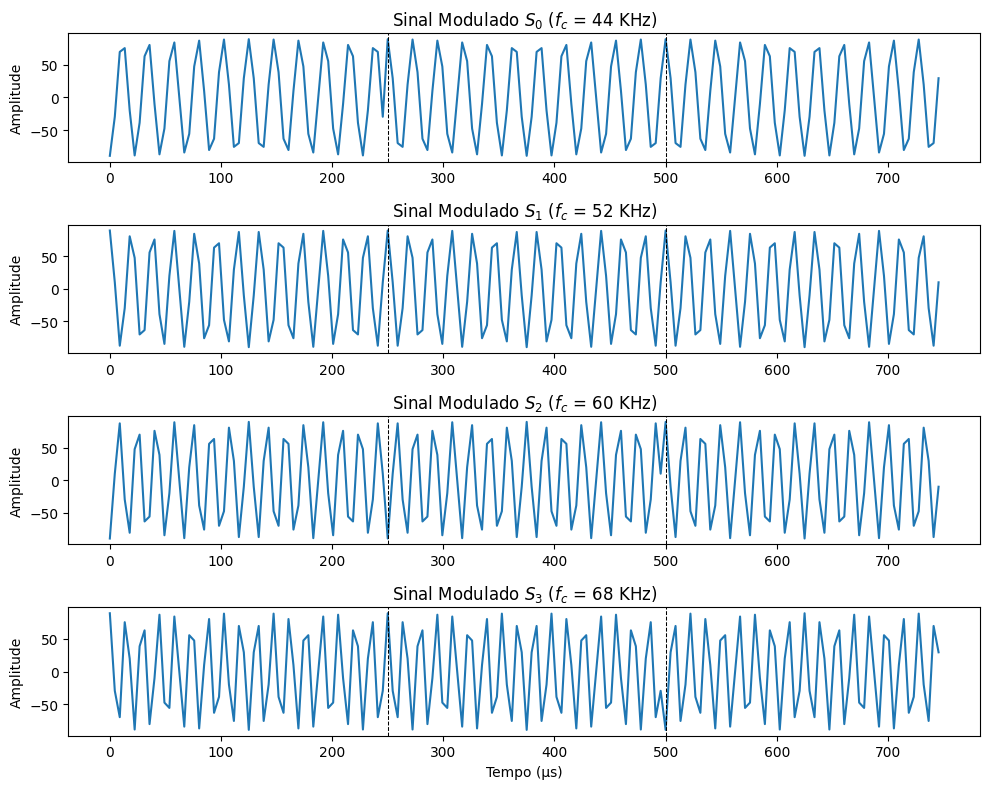

In [209]:
fig, axs = plt.subplots(len(bit_sequences), 1, figsize=(10, 8))

for i, (signal, fc) in enumerate(zip(fdm_modulated_signals, fc_values)):
    modulated_signal = modulate_signal(signal, fc, t)
    axs[i].plot(1e6 * t[:int(3*Fa*Ts)], modulated_signal[:int(3*Fa*Ts)])
    for k in range(1, 3):
        axs[i].axvline(k * Ts * 1e6, color='k', linestyle='--', linewidth=0.75)
    # axs[i].axvline(Ts * 1e6, color='k', linestyle='--')
    # axs[i].axvline(2 * Ts * 1e6, color='k', linestyle='--')
    
    axs[i].set_ylabel('Amplitude')
    axs[i].set_title(f'Sinal Modulado $S_{i}$ ($f_c$ = {int(fc/1e3)} KHz)')

axs[-1].set_xlabel('Tempo (μs)')
plt.tight_layout()
plt.show()

## Tarefa (e) - Densidade Espectral de Potência

Text(0.5, 1.0, 'Densidade Espectral de Potência dos Sinais FDM')

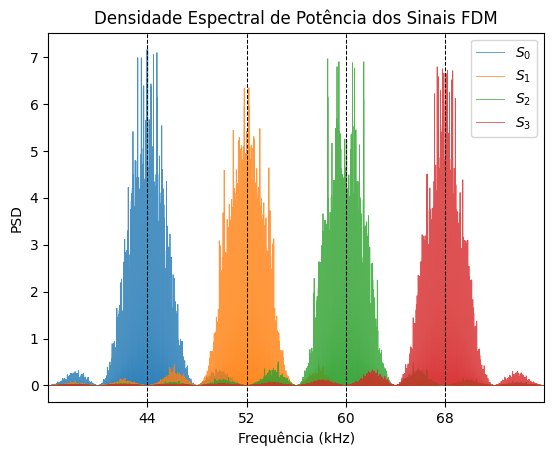

In [210]:
for i, (signal, fc) in enumerate(zip(fdm_modulated_signals, fc_values)):
    fdm_modulated_signal = modulate_signal(signal, fc, t)
    f, Pxx = periodogram(fdm_modulated_signal, Fa)
    plt.plot(f, Pxx, label=f'$S_{i}$', linewidth=0.6, alpha=0.8)
    # plot with 60% fill opacity
    plt.fill_between(f, Pxx, alpha=0.6)
    # plot vertical line with fc_values[i]
    plt.axvline(fc, color='k', linestyle='--', linewidth=0.75)
# show frequency values from fc_values / 1e3
# the x axis should be in kHz
plt.xticks(fc_values, [int(fc/1e3) for fc in fc_values])
plt.xlabel('Frequência (kHz)')


plt.legend()
plt.ylabel('PSD')
plt.xlim(36e3, 76e3)
plt.title(f'Densidade Espectral de Potência dos Sinais FDM')

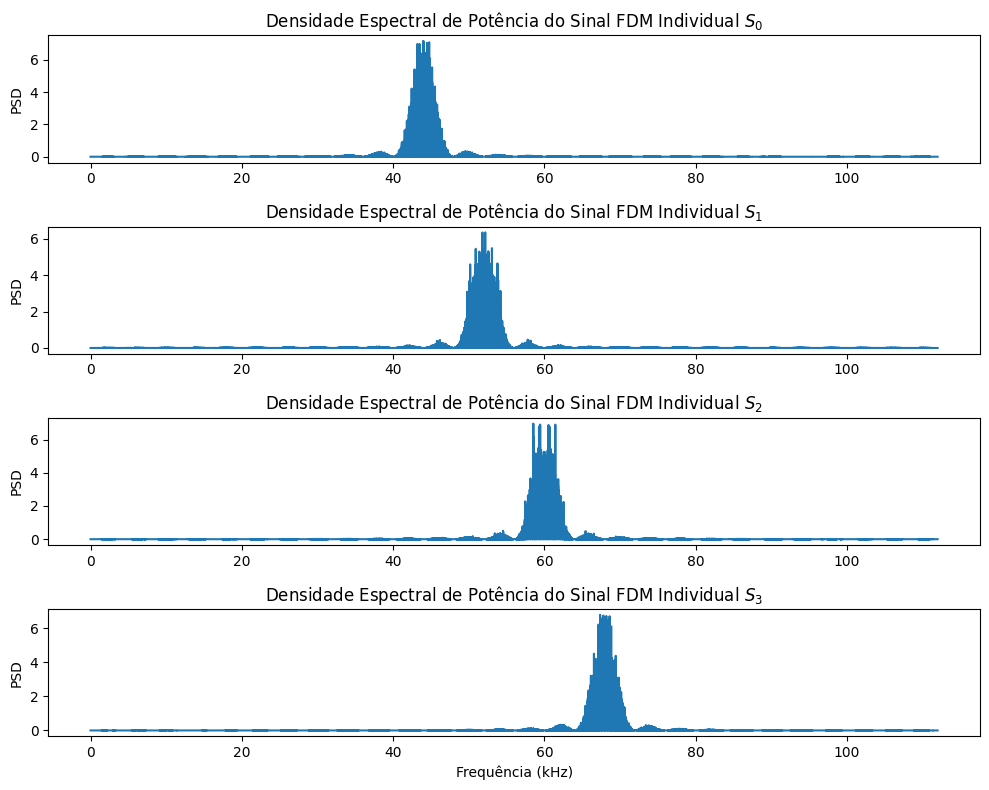

In [211]:
# Plotar a PSD de cada sinal FDM em um subplot separado
fig, axs = plt.subplots(4, 1, figsize=(10, 8))

for i, (signal, fc) in enumerate(zip(fdm_modulated_signals, fc_values)):
    modulated_signal = modulate_signal(signal, fc, t)
    f, Pxx = periodogram(modulated_signal, Fa)
    axs[i].plot(f / 1e3, Pxx)
    axs[i].set_ylabel('PSD')
    axs[i].set_title(f'Densidade Espectral de Potência do Sinal FDM Individual $S_{i}$')

plt.xlabel('Frequência (kHz)')
plt.tight_layout()
plt.show()

## Tarefa (f) - Ilustração da Técnica TDM

In [212]:
# O pulso para TDM deve ser 4 vezes menor que o de FDM
Ts_tdm = Ts / 4
tdm_signals = []
for bits in bit_sequences:
    t, sinal = generate_2PAM_sequence(bits, Ts_tdm, Fa)
    tdm_signals.append(sinal)
n = len(tdm_signals)  # Número de sinais
# quantas amostras de cada sinal cabem em um intervalo de tempo Ts_tdm
m = int(Fa * Ts_tdm)

# Cria um array para cada sinal que inclua os intervalos "desligados"
tdm_signal_arrays = []
for i in range(n):
    # Inicializa com zeros (sinal "desligado")
    tdm_array = np.zeros(len(tdm_signals[0]) * n)
   
    # Preenche o array com o sinal "ligado" em seu intervalo de tempo
    for j in range(len(tdm_signals[i]) // m):
        start_index = j * n * m + i * m
        end_index = start_index + m
        tdm_array[start_index:end_index] = tdm_signals[i][j * m: j * m + m]

    tdm_signal_arrays.append(tdm_array)
t_tdm = np.arange(0, len(tdm_signal_arrays[0]) / Fa, 1 / Fa)


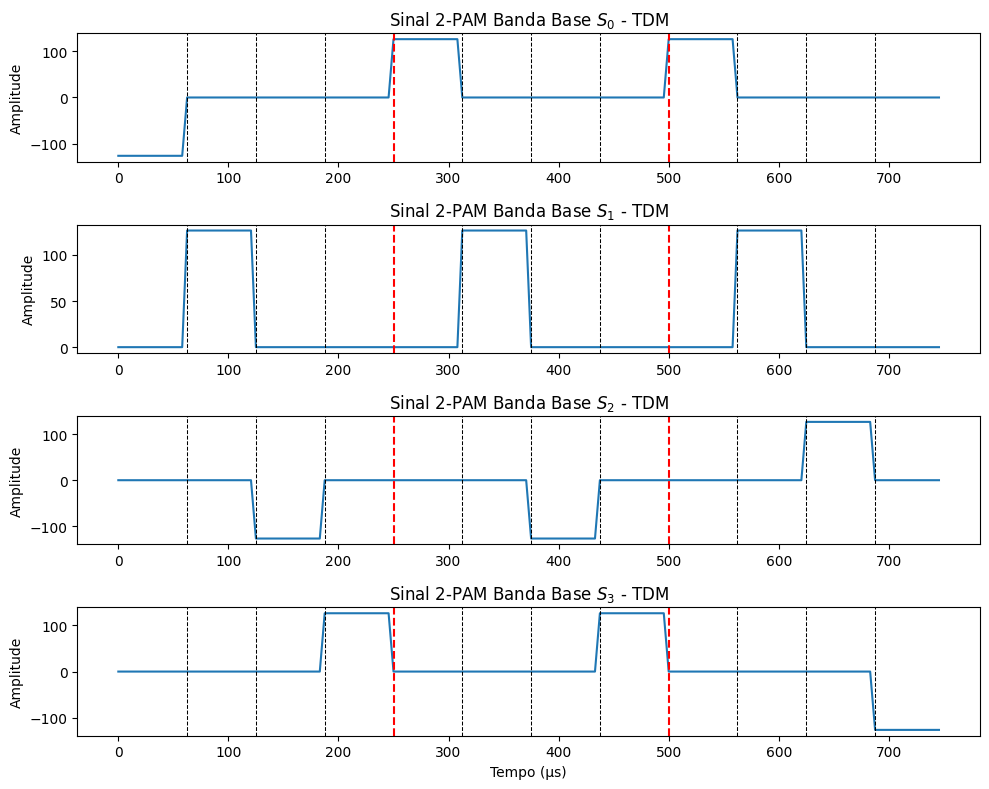

In [213]:
fig, axs = plt.subplots(len(tdm_signal_arrays), 1, figsize=(10, 8))

for i, tdm_array in enumerate(tdm_signal_arrays):
    modulated_signal = modulate_signal(signal, fc, t_tdm)
    axs[i].plot(1e6 * t_tdm[:int(12*Fa*Ts_tdm)], tdm_array[:int(12*Fa*Ts_tdm)])
    axs[i].axvline(Ts * 1e6, color='r', linestyle='--')
    axs[i].axvline(2 * Ts * 1e6, color='r', linestyle='--')
    for j in range(12):
        if j % 4 != 0:
            axs[i].axvline(j * Ts_tdm * 1e6, color='k', linestyle='--', linewidth=0.75)
    axs[i].set_ylabel('Amplitude')
    axs[i].set_title(f'Sinal 2-PAM Banda Base $S_{i}$ - TDM')

plt.xlabel('Tempo (μs)')
plt.tight_layout()
plt.show()

## Tarefa (g) - Geração do Sinal Multiplexado no Tempo para TDM

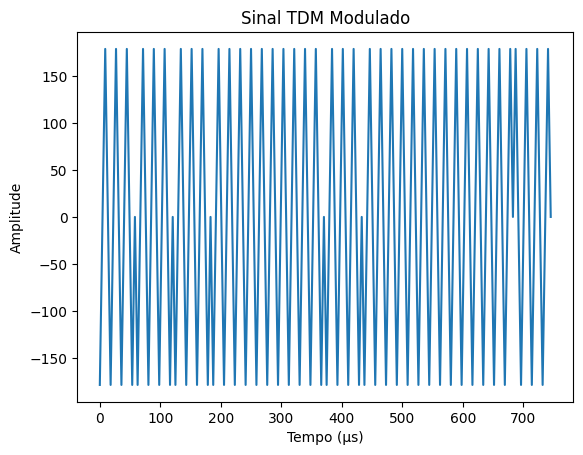

In [214]:
# Definição da frequência da portadora para a modulação
fc = 56000  # 56.000 Hz

# Combinar todos os sinais TDM em um único sinal
combined_tdm_signal = np.sum(tdm_signal_arrays, axis=0)

# Modulação do sinal TDM combinado
modulated_tdm_signal = modulate_signal(combined_tdm_signal, fc, t_tdm)

# Plot do sinal TDM modulado
plt.plot(1e6 * t_tdm[:int(12*Fa*Ts_tdm)], modulated_tdm_signal[:int(12*Fa*Ts_tdm)])
plt.xlabel('Tempo (μs)')
plt.ylabel('Amplitude')
plt.title('Sinal TDM Modulado')
plt.show()


## Tarefa (h) - Visualização no Domínio do Tempo para TDM

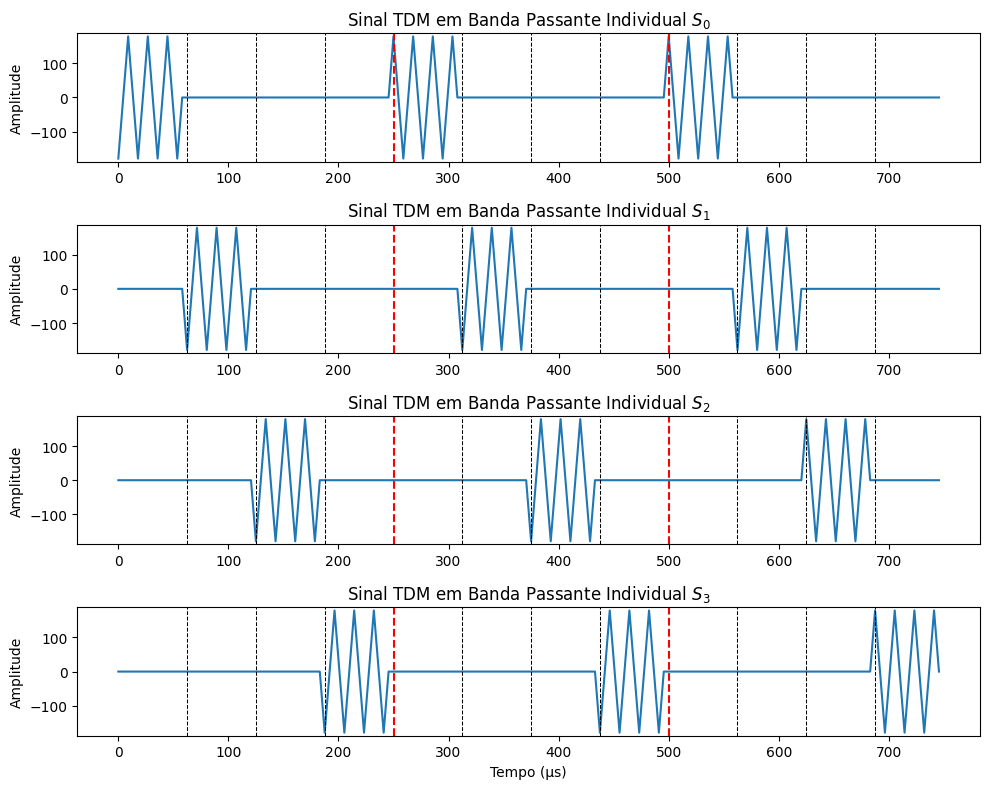

In [215]:
# Definindo o intervalo de tempo para os gráficos
time_interval_tdm = int(12 * Fa * Ts_tdm)
t_tdm_plot = 1e6 * t_tdm[:time_interval_tdm]  # Tempo em microssegundos

# Criar uma figura com 4 subplots (ou o número de sinais TDM que você tem)
fig, axs = plt.subplots(len(tdm_signal_arrays), 1, figsize=(10, 8))


# Plotar cada sinal TDM em um subplot separado
for i, tdm_array in enumerate(tdm_signal_arrays):
    modulated_tdm_array = modulate_signal(tdm_array, fc, t_tdm)
    max_y = np.max(np.abs(modulated_tdm_array[:time_interval_tdm]))
    axs[i].plot(t_tdm_plot, modulated_tdm_array[:time_interval_tdm])
    axs[i].axvline(Ts * 1e6, color='r', linestyle='--')
    axs[i].axvline(2 * Ts * 1e6, color='r', linestyle='--')
    for j in range(12):
        if j % 4 != 0:
            axs[i].axvline(j * Ts_tdm * 1e6, color='k', linestyle='--', linewidth=0.75)
    axs[i].set_ylim([-1.05 * max_y, 1.05 * max_y])
    axs[i].set_ylabel('Amplitude')
    axs[i].set_title(f'Sinal TDM em Banda Passante Individual $S_{i}$')

# Ajustar o layout
axs[-1].set_xlabel('Tempo (μs)')
plt.tight_layout()
plt.show()

## Tarefa (i) - Densidade Espectral de Potência para TDM

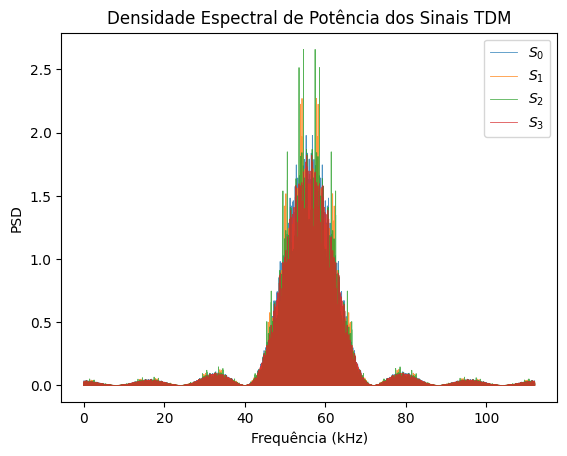

In [216]:
# Criar figura única para a PSD de cada sinal TDM
plt.figure()

# Plotar cada sinal TDM em um subplot separado
for i, tdm_array in enumerate(tdm_signal_arrays):
    modulated_tdm_array = modulate_signal(tdm_array, fc, t_tdm)
    f_tdm, Pxx_tdm = periodogram(modulated_tdm_array, Fa)
    plt.plot(f_tdm / 1e3, Pxx_tdm, label=f'$S_{i}$', alpha=0.8, linewidth=0.6)

plt.xlabel('Frequência (kHz)')
plt.ylabel('PSD')
plt.title('Densidade Espectral de Potência dos Sinais TDM')
plt.legend()
plt.show()

## Tarefa (j) - Ilustração da Técnica CDM

In [217]:
def cdm_spreading(s, spread):
    m = len(spread)
    s_ = np.repeat(s, m)
    tile_count = len(s_) // m + 1
    spread_ = np.tile(spread, tile_count)[:len(s_)]
    return s_, spread_

In [218]:
# Sequências de espalhamento
spreading_sequences = np.array([[0, 0, 1, 1, 1, 0, 1],
                                [0, 1, 1, 1, 0, 1, 0],
                                [1, 1, 1, 0, 1, 0, 0],
                                [1, 1, 0, 1, 0, 0, 1]])
fc = 56000
cdm_signals = []
for bits, spread_seq in zip(bit_sequences, spreading_sequences):
    s_, spread_ = cdm_spreading(bits, spread_seq)
    spread_bits = s_ ^ spread_
    m = len(spread_seq)
    t, sinal_espalhado_banda_base = generate_2PAM_sequence(spread_bits, Ts/m, Fa)
    _, sinal_espalhamento_banda_base = generate_2PAM_sequence(spread_, Ts/m, Fa)
    _, sinal_original_banda_base = generate_2PAM_sequence(s_, Ts/m, Fa)
    
    d = {
        't': t,
        'sinal_espalhado_banda_base': sinal_espalhado_banda_base, # sinal espalhado em 2-PAM banda base
        'sinal_espalhamento_banda_base': sinal_espalhamento_banda_base, # sinal de espalhamento em 2-PAM banda base
        'sinal_original_banda_base': sinal_original_banda_base, # sinal original em 2-PAM banda base
        # Modulado em banda passante: (tarefa k)
        'sinal_espalhado_banda_passante': modulate_signal(sinal_espalhado_banda_base, fc, t),
        'sinal_espalhamento_banda_passante': modulate_signal(sinal_espalhamento_banda_base, fc, t),
        # Redundante:
        'bits': s_, # bits originais, reamostrados m vezes
        'spread': spread_, # bits da sequência de espalhamento expandidos
    }
    cdm_signals.append(d)


## Tarefa (k) - Geração do Sinal Multiplexado no Tempo para CDM

## Tarefa (l) - Visualização no Domínio do Tempo para CDM

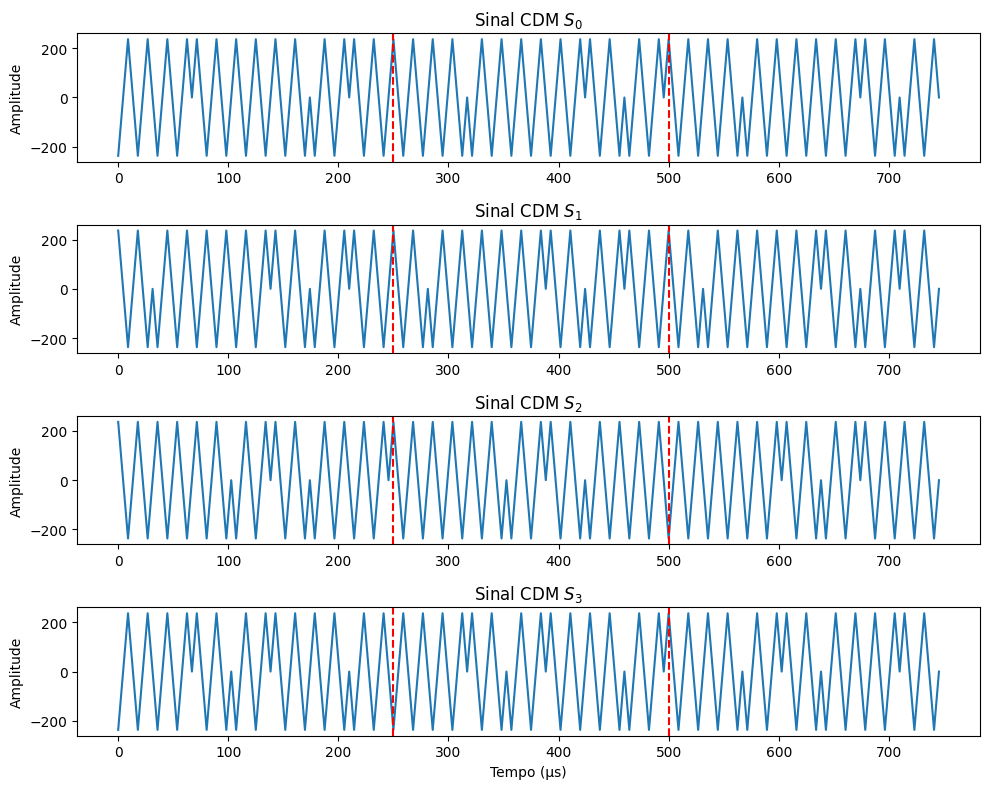

In [219]:
# Definindo o intervalo de tempo para os três primeiros símbolos
time_interval = int(3 * Fa * Ts)
t_plot = 1e6 * t[:time_interval]  # Tempo em microssegundos

# Criar uma figura com 4 subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 8))

# Plotar cada sinal CDM em um subplot separado
for i, cdm_dict in enumerate(cdm_signals):
    sinal_mod = cdm_dict['sinal_espalhado_banda_passante']
    axs[i].plot(1e6 * t[:int(3*Fa*Ts)], sinal_mod[:time_interval])
    axs[i].axvline(Ts * 1e6, color='r', linestyle='--')
    axs[i].axvline(2 * Ts * 1e6, color='r', linestyle='--')
    axs[i].set_title(f'Sinal CDM $S_{i}$')
    axs[i].set_ylabel('Amplitude')

# Ajustar o layout
plt.xlabel('Tempo (μs)')
plt.tight_layout()
plt.show()


## Tarefa (m) - Densidade Espectral de Potência para CDM

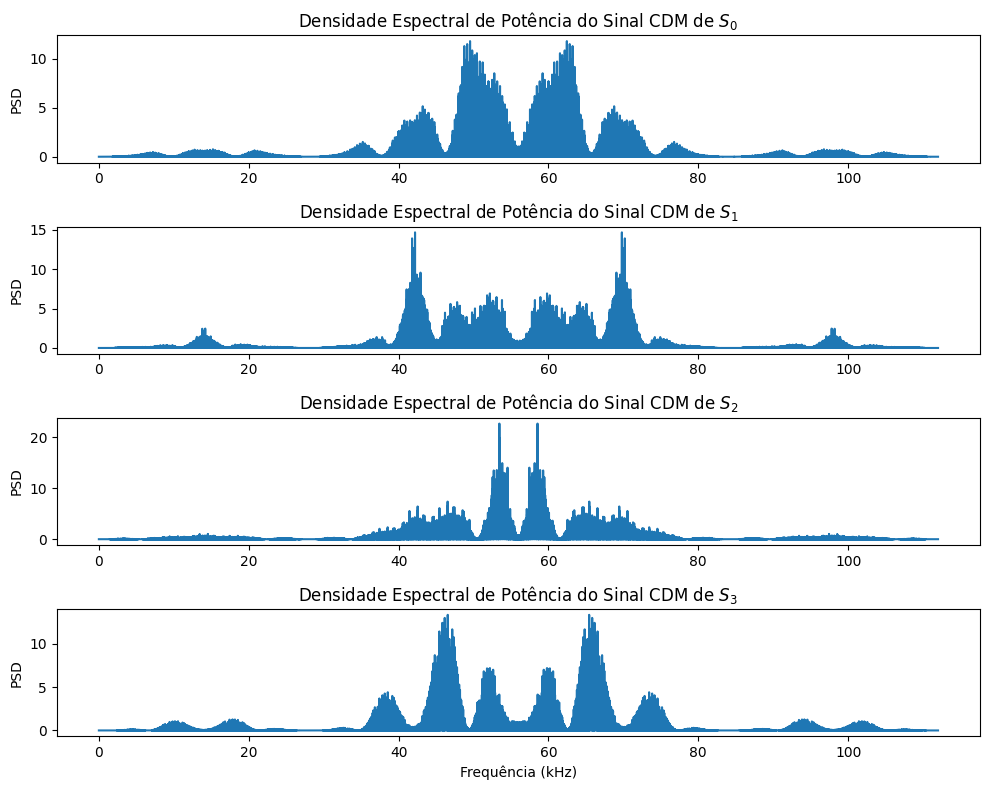

In [220]:
# Criar uma figura com 4 subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 8))

for i, cdm_dict in enumerate(cdm_signals):
    sinal_mod = cdm_dict['sinal_espalhado_banda_passante']
    f_cdm, Pxx_cdm = periodogram(sinal_mod, Fa)
    
    axs[i].plot(f_cdm / 1e3, Pxx_cdm)
    axs[i].set_title(f'Densidade Espectral de Potência do Sinal CDM de $S_{i}$')
    axs[i].set_ylabel('PSD')

axs[-1].set_xlabel('Frequência (kHz)')
plt.tight_layout()
plt.show()

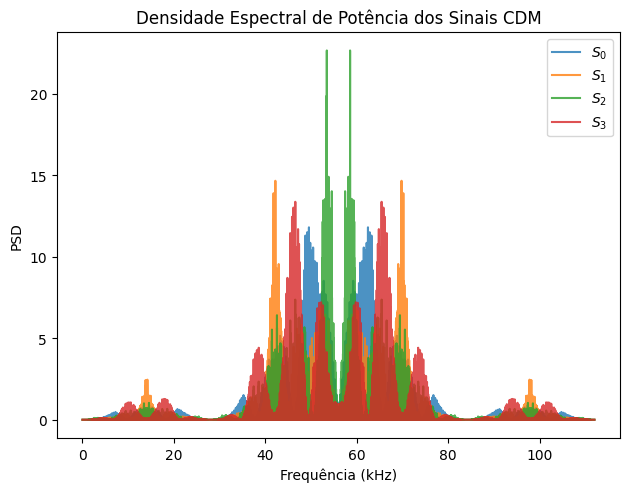

In [225]:
# Criar uma figura única
plt.figure()

for i, cdm_dict in enumerate(cdm_signals):
    sinal_mod = cdm_dict['sinal_espalhado_banda_passante']
    f_cdm, Pxx_cdm = periodogram(sinal_mod, Fa)
    
    plt.plot(f_cdm / 1e3, Pxx_cdm, label=f'$S_{i}$', alpha=0.8)
    plt.ylabel('PSD')

plt.xlabel('Frequência (kHz)')
plt.tight_layout()
plt.title('Densidade Espectral de Potência dos Sinais CDM')
plt.legend()
plt.show()

## Tarefa (n) - Experimento com Sequências de Espalhamento

### Tabela XOR

| XOR | 0 | 1 |
|-----|---|---|
| 0   | 0 | 1 |
| 1   | 1 | 0 |

### Tabela MULTIPLICAÇÃO 2-PAM


| PAM | 0 | 1 |
|-----|---|---|
| 0   | 1 | 0 |
| 1   | 0 | 1 |

$$f(x) = \begin{cases}
-1, & \text{se } x = 0 \\
+1, & \text{se } x = 1
\end{cases}$$

Conceitualmente, a operação de multiplicação 2-PAM é equivalente à operação de NOT XOR. Ou seja, se temos duas sequências binárias (i.e. de valores $v \in \{0, 1\}$) $x[k]$ e $y[k]$, podemos representá-las como sinais 2-PAM $x_p[k]$ e $y_p[k]$ da seguinte forma:

$$x_p[k] = f(x[k]) \quad \text{e} \quad y_p[k] = f(y[k])$$

multiplicando-as, obtemos $z_p[k] = x_p[k] \cdot y_p[k]$.

Vejamos a tabela de multiplicação:

| MUL | -1 | +1 |
|-----|----|----|
| -1  | +1 | -1 |
| +1  | -1 | +1 |

agora, para voltar para o domínio binário, basta aplicar a função $f^{-1}(x)$. Perceba que primeiro devemos inverter o sinal, e depois aplicar a função $f^{-1}(x)$, de tal forma que:

$$z[k] = f^{-1}(-z_p[k])$$

Ou seja:

$$x[k] \oplus y[k] = f^{-1}(-x_p[k] \cdot y_p[k])$$

Ou, equivalentemente:

$$x_p[k] \cdot y_p[k] = -f(x[k] \oplus y[k])$$

Assim, como o CDM envolve uma operação de XOR, podemos esperar que a etapa de desespalhamento, a qual envolve uma operação de multiplicação 2-PAM, modifique apenas a fase do sinal, mas não sua amplitude, no espectro de frequências:

$$\mathcal{F}\{-x[k]\} = -\mathcal{F}\{x[k]\}$$

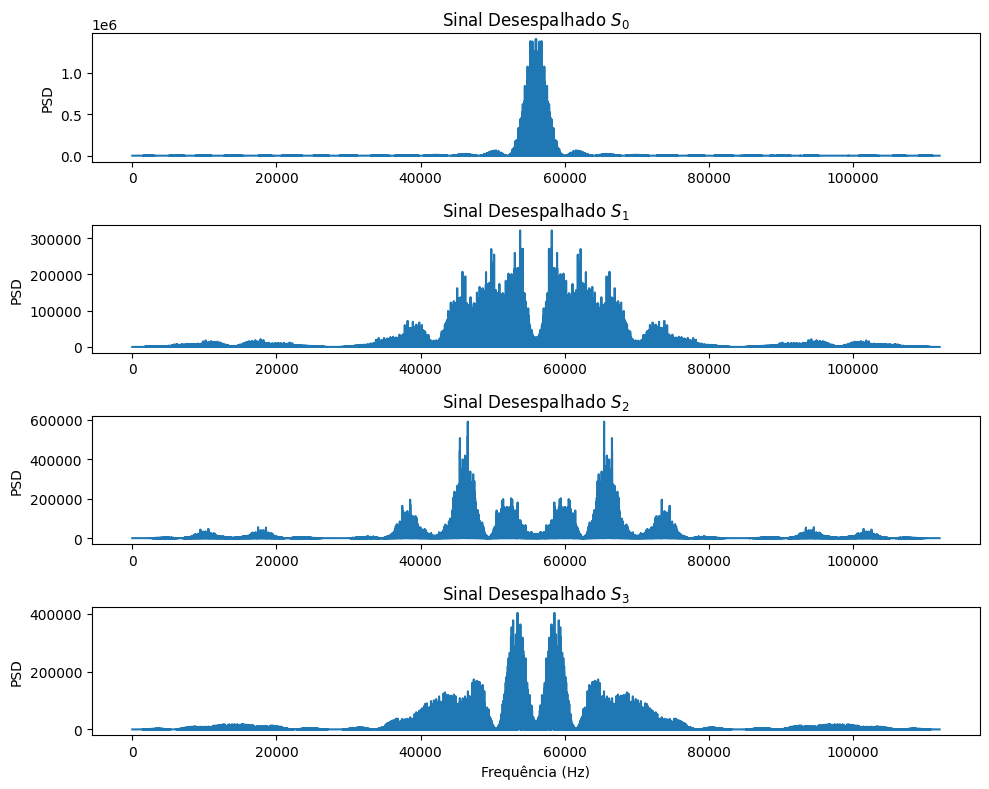

In [226]:
# Visualização no domínio da frequência
fig, axs = plt.subplots(4, 1, figsize=(10, 8))

# Escolher um sinal de espalhamento para multiplicar com o sinal espalhado
sinal_spread = cdm_signals[0].get('sinal_espalhamento_banda_base')

for i, cdm_dict in enumerate(cdm_signals):
    sinal = cdm_dict.get('sinal_espalhado_banda_passante')
    mult_sinais = sinal * sinal_spread
    
    f_cdm, Pxx_cdm = periodogram(mult_sinais, Fa)
    axs[i].plot(f_cdm, Pxx_cdm)
    axs[i].set_ylabel('PSD')
    axs[i].set_title(f'Sinal Desespalhado $S_{i}$')

axs[-1].set_xlabel('Frequência (Hz)')
plt.tight_layout()
plt.show()

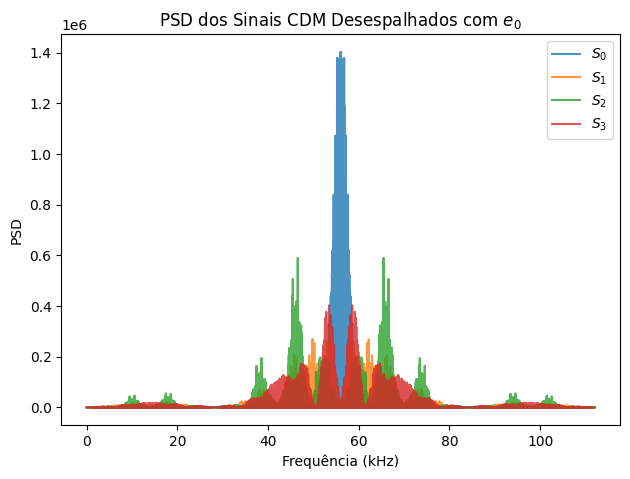

In [227]:
plt.figure()

# Escolher um sinal de espalhamento para multiplicar com o sinal espalhado
sinal_spread = cdm_signals[0].get('sinal_espalhamento_banda_base')

for i, cdm_dict in enumerate(cdm_signals):
    sinal = cdm_dict.get('sinal_espalhado_banda_passante')
    mult_sinais = sinal * sinal_spread
    
    f_cdm, Pxx_cdm = periodogram(mult_sinais, Fa)
    plt.plot(f_cdm / 1e3, Pxx_cdm, label=f'$S_{i}$', alpha=0.8)
    plt.ylabel('PSD')

plt.xlabel('Frequência (kHz)')
plt.tight_layout()
plt.title('PSD dos Sinais CDM Desespalhados com $e_0$')
plt.legend()
plt.show()